In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
#!pip install tqdm
from tqdm import tqdm #progress bar
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import pearsonr
from scipy import stats
import requests
import json
import time
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
#! pip install xgboost
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA

In [2]:
excel_file_path = r"C:\Users\Qihang Tang\OneDrive\桌面\APAN\Capstone\RC Projection data since 2022 28AUG24.xlsx"

excel_file = pd.ExcelFile(excel_file_path)

sheets_to_load = ['2022', '2023', '2024', 'Workday Calendar', 'Location hierarchy', 'Fleet Count']

dfs = {}

for sheet in tqdm(sheets_to_load, desc="Loading sheets"):
    dfs[sheet] = pd.read_excel(excel_file, sheet_name=sheet)

df_2022 = dfs['2022']
df_2023 = dfs['2023']
df_2024 = dfs['2024']
workday_calendar = dfs['Workday Calendar']
location_df = dfs['Location hierarchy']
fleet_count = dfs['Fleet Count']

Loading sheets: 100%|████████████████████████████████████████████████████████████████████| 6/6 [03:30<00:00, 35.08s/it]


In [3]:
df_total = pd.concat([df_2022, df_2023, df_2024], axis=0, ignore_index=True)
df_total = df_total.loc[:, ~df_total.columns.str.contains('^Unnamed')]
workday_months = workday_calendar[['MONTH', 'WD_IN_MNTH', 'DAYS_IN_MNTH', 'SATURDAY_COUNT', 'WEEKDAY_HOLIDAYS']]
workday_months = workday_months.dropna(how='all')

workday_days = workday_calendar[['MONTH.1', 'DT', 'DT_KEY', 'WD_IN_MNTH.1', 'DAYS_IN_MNTH.1', 'SATURDAY_COUNT.1', 'WEEKDAY_HOLIDAYS.1',
                                'Saturdays in Month', 'Workdays in Month', 'Max Workday', 'Max Saturday',
                                'WD Remaining', 'Saturday Remaining']]

In [5]:
df_total.columns

Index(['MONTH', 'YEAR', 'GL_TRANSACTION_EFFECTIVE_DT', 'GL_EFF_WD_NBR',
       'FIN_SOURCE_TYPE_DESC', 'LOCATION_CD', 'LOCATION_DESC', 'BU_DESC',
       'REGION_DESC', 'TRANSACTION_AMOUNT'],
      dtype='object')

In [6]:
print(df_total['GL_TRANSACTION_EFFECTIVE_DT'].dtype)

datetime64[ns]


In [16]:
daily_cost = df_total[['GL_TRANSACTION_EFFECTIVE_DT','TRANSACTION_AMOUNT']].groupby(df_total['GL_TRANSACTION_EFFECTIVE_DT']).sum()

In [17]:
daily_cost

,TRANSACTION_AMOUNT
GL_TRANSACTION_EFFECTIVE_DT,
2022-01-02,27352.00
2022-01-03,-75474.28
2022-01-04,1886477.74
2022-01-05,2538613.52
2022-01-06,2526572.20
...,...
2024-08-23,320023.56
2024-08-24,3411333.05
2024-08-25,83911.39


In [18]:
monthly_cost = daily_cost.resample('M').sum()

In [19]:
monthly_cost

,TRANSACTION_AMOUNT
GL_TRANSACTION_EFFECTIVE_DT,
2022-01-31,67470454.28
2022-02-28,72296079.19
2022-03-31,83803003.11
2022-04-30,72017569.35
2022-05-31,78738462.15
2022-06-30,77517497.17
2022-07-31,77740491.47
2022-08-31,86372363.07
2022-09-30,82325584.91


<Figure size 3600x2160 with 0 Axes>

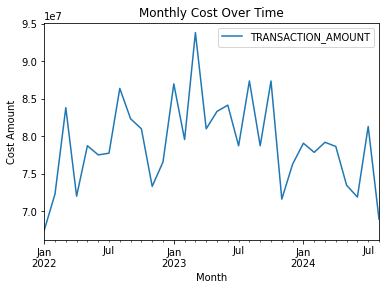

In [28]:
plt.figure(figsize=(50, 30))

monthly_cost.plot()
plt.title('Monthly Cost Over Time')
plt.xlabel('Month')
plt.ylabel('Cost Amount')

plt.show()

In [30]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_cost['TRANSACTION_AMOUNT'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.163477
p-value: 0.022199
Critical Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621


In [43]:
#!pip install prophet pandas
import pandas as pd
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_error

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.6.2 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.4 which is incompatible.
Importing plotly failed. Interactive plots will not work.


  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1


In [55]:
# Function to reshape daily cost data into monthly windows using index as date
def create_daily_features(df, N):
    df = df.copy()
    
    # Ensure the index is in datetime format
    df.index = pd.to_datetime(df.index)
    
    # Extract the month from the index (date)
    df['month'] = df.index.to_period('M')
    
    # Group by month and select the first N daily costs
    daily_features = df.groupby('month')['TRANSACTION_AMOUNT'].apply(lambda x: list(x)[:N]).reset_index()
    
    # Add the N value used
    daily_features['N'] = N
    return daily_features

In [60]:
create_daily_features(daily_cost,5)

,month,TRANSACTION_AMOUNT,N
0,2022-01,"[27352.0, -75474.2800000001, 1886477.739999998...",5
1,2022-02,"[1953231.7100000007, 3711109.299999999, 272299...",5
2,2022-03,"[1543466.6199999955, 5584284.899999992, 318589...",5
3,2022-04,"[1743582.729999999, 193197.56000000003, 269899...",5
4,2022-05,"[2001798.5900000003, 146580.59000000008, 48376...",5
5,2022-06,"[1724320.2599999984, 4690624.939999995, 344223...",5
6,2022-07,"[516143.8100000001, 1563894.3100000003, 327840...",5
7,2022-08,"[1665377.080000001, 4167710.9899999914, 392338...",5
8,2022-09,"[2015758.2599999998, 4500793.240000004, 8315.4...",5
9,2022-10,"[33498.130000000005, 59647.47999999999, -1757....",5


In [76]:
def train_predict_prophet(daily_df, N_values, window_values, monthly_df):
    results = []

    for N in N_values:
        daily_features = create_daily_features(daily_df, N)

        for window in window_values:
            for i in range(len(daily_features) - window):
                # Prepare training data
                train_data = daily_features.iloc[i:i+window]
                train_months = monthly_df.iloc[i:i+window]
                #print(train_months)

                # Create Prophet model and fit on training data
                prophet_df = pd.DataFrame({'ds': train_months.index.astype(str), 'y': train_months['TRANSACTION_AMOUNT']})
                
                 # Skip if there are fewer than 2 valid rows
                if prophet_df.dropna().shape[0] < 2:
                    continue  # Skip this iteration if there's not enough data

                model = Prophet()
                model.fit(prophet_df)

                # Make future dataframe for the next month
                future = pd.DataFrame({'ds': [daily_features['month'].iloc[i+window].astype(str)]})
                forecast = model.predict(future)

                # Calculate error between forecast and true value
                actual = monthly_df['monthly_cost'].iloc[i+window]
                predicted = forecast['yhat'].values[0]
                error = mean_absolute_error([actual], [predicted])

                results.append({
                    'N': N,
                    'window': window,
                    'actual': actual,
                    'predicted': predicted,
                    'error': error
                })
    return pd.DataFrame(results)

In [77]:
# Test N values (number of days) and window sizes
N_values = [5, 8, 10, 12, 15, 21]
window_values = [1, 2]

result_df = train_predict_prophet(daily_cost, N_values, window_values, monthly_cost)

                                     ds            y
GL_TRANSACTION_EFFECTIVE_DT                         
2022-01-31                   2022-01-31  67470454.28
2022-02-28                   2022-02-28  72296079.19


22:22:40 - cmdstanpy - INFO - Chain [1] start processing
22:22:42 - cmdstanpy - INFO - Chain [1] done processing
22:22:42 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization! Command 'C:\Anoconda3\Lib\site-packages\prophet\stan_model\prophet_model.bin random seed=68869 data file=C:\Users\QIHANG~1\AppData\Local\Temp\tmpoksp48g7\r_uhxn5b.json init=C:\Users\QIHANG~1\AppData\Local\Temp\tmpoksp48g7\ci561ede.json output file=C:\Users\QIHANG~1\AppData\Local\Temp\tmpoksp48g7\prophet_model71bwgt3g\prophet_model-20240928222240.csv method=optimize algorithm=newton iter=10000' failed: 

In [40]:
from statsmodels.tsa.arima.model import ARIMA

train = monthly_cost[monthly_cost.index < '2023-01-01']
test = monthly_cost[(monthly_cost.index >= '2023-01-01') & (monthly_cost.index < '2024-01-01')]

# Fit ARIMA model
model = ARIMA(train['TRANSACTION_AMOUNT'], order=(1,0,1))
model_fit = model.fit()

start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end, typ='levels')

mse = mean_squared_error(test['TRANSACTION_AMOUNT'], predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 55165403346026.375


C:\Anoconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anoconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


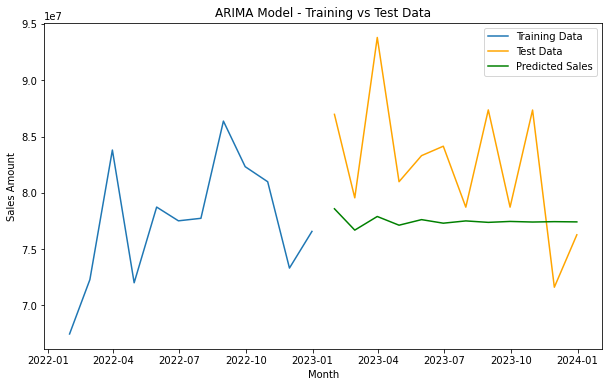

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['TRANSACTION_AMOUNT'], label='Training Data')
plt.plot(test.index, test['TRANSACTION_AMOUNT'], label='Test Data', color='orange')
plt.plot(test.index, predictions, label='Predicted Sales', color='green')
plt.title('ARIMA Model - Training vs Test Data')
plt.xlabel('Month')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()